In [1]:
%load_ext rpy2.ipython
%matplotlib inline

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Во время загрузки - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Предупреждения:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [2]:
from cmath import log

import psycopg2
from pandas import read_csv, DataFrame
from psycopg2.extras import DictCursor
from rpy2.robjects import pandas2ri, R, vectors
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import importr
import statsmodels.api as sm
from pandas.core import datetools
import matplotlib.pyplot as plt

from science.collector.service.poloniex_public_service import PoloniexPublicService


pandas2ri.activate()

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
connection = psycopg2.connect("dbname=deep_crypto user=postgres password=postgres host=localhost port=5432")
cursor = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)

poloniexPublicService = PoloniexPublicService(connection, cursor)

poloniexPublicService.saveChartDataToCSV(main_currency='BTC', secondary_currency='ETH', start='1509483600',
                                         end='1514754000', period='300')

In [4]:
dataset = read_csv('dataset.csv', index_col=['date'], parse_dates=['date'], dayfirst=True,
                   usecols=['date', 'weighted_average'])

dataset

,weighted_average
date,
2017-11-02 10:00:00,0.040149
2017-11-01 08:40:00,0.047356
2017-11-01 02:20:00,0.047448
2017-11-01 02:25:00,0.047411
2017-11-01 02:30:00,0.047349
2017-11-01 02:35:00,0.047323
2017-11-01 02:40:00,0.047213
2017-11-01 02:45:00,0.047195
2017-11-01 02:50:00,0.047010


In [5]:
#dataset['weighted_average'] = dataset['weighted_average'].apply(lambda w: log(w))

In [6]:
stats = importr('stats')
tseries = importr('tseries')

In [7]:
dim = 504

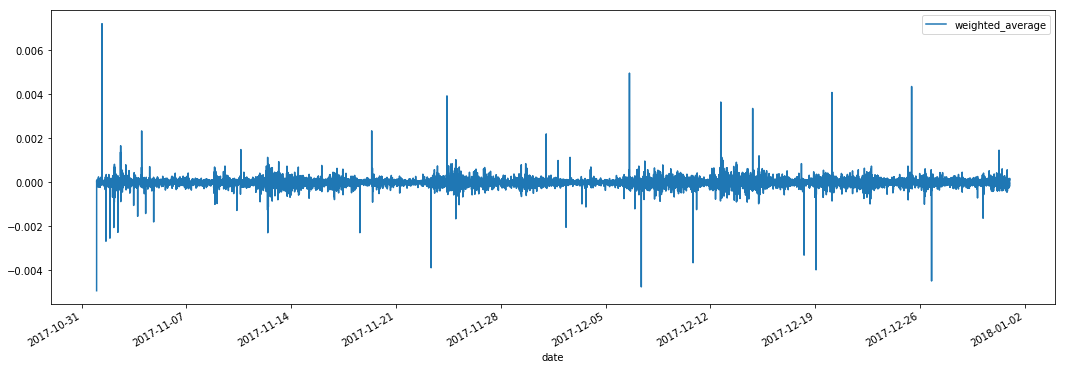

In [8]:
diff1lev = dataset.diff(periods=1).dropna()

diff1lev.plot(figsize=(18, 6))

In [9]:
diff1lev_season = diff1lev.diff(dim).dropna()

In [10]:
r_df = pandas2ri.py2ri(DataFrame(diff1lev_season))
y = stats.ts(r_df)
ad = tseries.adf_test(y, alternative="stationary", k=dim)
a = ad.names[:5]

In [11]:
{ad.names[i]:ad[i][0] for i in range(len(a))}

{'alternative': 'stationary',
 'method': 'Augmented Dickey-Fuller Test',
 'p.value': 0.01,
 'parameter': 504.0,
 'statistic': -9.65260432872939}

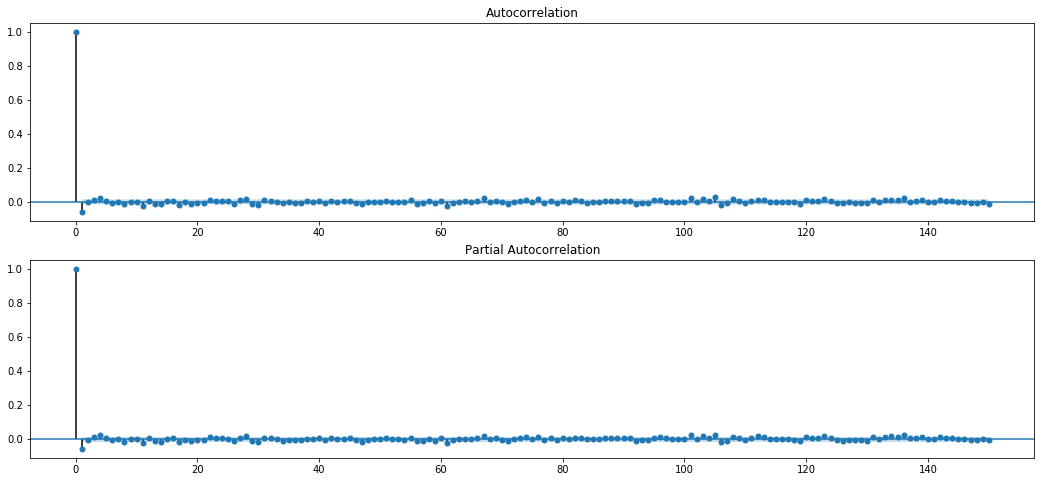

In [12]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1lev_season.values.squeeze(), lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1lev_season, lags=150, ax=ax2)

In [13]:
r_df = pandas2ri.py2ri(DataFrame(diff1lev_season))
y = stats.ts(r_df)

In [14]:
order = vectors.IntVector((4,1,13))

In [ ]:
season = vectors.ListVector({'order': vectors.IntVector((0,1,0)), 'period' : dim})

In [ ]:
model = stats.arima(y, order = order, seasonal=season)

In [ ]:
%Rpush model
%R tsdiag(model, 100)